# Train a small transformer model on preprocessed segments

This notebook loads `segments_preproc_24.csv` produced by the preprocessing notebook, builds segment-level sequences, and trains a small transformer-based classifier.

In [1]:
# Imports and configuration
import os
import math
import numpy as np
import pandas as pd
from typing import Dict, Any

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, 
    auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")

print("Using preprocessed file:", PREPROC_CSV)
assert os.path.exists(PREPROC_CSV), f"Preprocessed CSV not found: {PREPROC_CSV}"
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using preprocessed file: /work/data/export/segments_preproc_24.csv
PyTorch Lightning version: 2.6.0
CUDA available: True


In [2]:
# Set random seeds for reproducibility
SEED = 1
seed_everything(SEED, workers=True)
print(f"Random seed locked to {SEED}")

Seed set to 1


Random seed locked to 1


In [3]:
# Model evaluation configuration
# Change this single variable to switch the primary metric for model selection
# Options: 'auc_ovo', 'auc_ovr', 'f1', 'accuracy', 'pr_auc'
PRIMARY_METRIC = 'pr_auc'

# Metric display names and whether higher is better
METRIC_CONFIG = {
    'auc_ovo': {
        'name': 'AUC-ROC (OvO)',
        'short': 'ovo',
        'higher_is_better': True,
        'monitor': 'val_auc_ovo',
        'description': 'One-vs-One: evaluates all pairwise class comparisons'
    },
    'auc_ovr': {
        'name': 'AUC-ROC (OvR)',
        'short': 'ovr',
        'higher_is_better': True,
        'monitor': 'val_auc_ovr',
        'description': 'One-vs-Rest: evaluates each class vs all others'
    },
    'f1': {
        'name': 'F1 Score (macro)',
        'short': 'f1',
        'higher_is_better': True,
        'monitor': 'val_f1',
        'description': 'Harmonic mean of precision and recall'
    },
    'accuracy': {
        'name': 'Accuracy',
        'short': 'acc',
        'higher_is_better': True,
        'monitor': 'val_accuracy',
        'description': 'Proportion of correct predictions'
    },
    'pr_auc': {
        'name': 'PR-AUC (macro)',
        'short': 'pr',
        'higher_is_better': True,
        'monitor': 'val_pr_auc',
        'description': 'Precision-Recall curve area (macro): better for imbalanced classes'
    }
}

print(f"Primary metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
print(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")

Primary metric: PR-AUC (macro)
Description: Precision-Recall curve area (macro): better for imbalanced classes


In [4]:
# Load preprocessed dataset and build segment-level sequences
df = pd.read_csv(PREPROC_CSV)
print("Raw preprocessed shape:", df.shape)

# Ensure correct ordering within each segment
df = df.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

feature_cols = [c for c in df.columns if c not in ["segment_id", "label", "csv_file", "seq_pos"]]
print("Feature columns (", len(feature_cols), "):", feature_cols)

# Group into (segment, sequence of length 24, label)
segments = []
labels = []

for seg_id, g in df.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    # Expect 24 steps; if shorter/longer, adjust with simple strategies
    if feat.shape[0] < 24:
        # pad by repeating last step
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        # truncate extra steps
        feat = feat[:24, :]

    assert feat.shape[0] == 24, feat.shape
    segments.append(feat)
    labels.append(g["label"].iloc[0])

X = np.stack(segments, axis=0)  # (N, 24, F)
y = np.array(labels)

print("Num segments:", X.shape[0], "Seq len:", X.shape[1], "Num features:", X.shape[2])
print("Label distribution:")
print(pd.Series(y).value_counts())

Raw preprocessed shape: (3456, 12)
Feature columns ( 8 ): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
Num segments: 144 Seq len: 24 Num features: 8
Label distribution:
Bullish Normal     40
Bearish Normal     27
Bearish Pennant    26
Bullish Pennant    22
Bullish Wedge      15
Bearish Wedge      14
Name: count, dtype: int64


In [5]:
# Encode labels as integers
label_values = np.sort(pd.unique(y))
label_to_idx = {lbl: i for i, lbl in enumerate(label_values)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

y_idx = np.vectorize(label_to_idx.get)(y)
num_classes = len(label_values)
print("Classes:", label_values, "-> num_classes =", num_classes)

Classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge'] -> num_classes = 6


In [6]:
# Train/validation split at segment level
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx, test_size=0.2, random_state=SEED, stratify=y_idx,
 )

print("Train segments:", X_train.shape[0])
print("Val segments:", X_val.shape[0])

class SegmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SegmentDataset(X_train, y_train)
val_ds = SegmentDataset(X_val, y_val)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_idx)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
print(f"Class distribution: {class_counts}")
print(f"Class weights: {class_weights}")

Train segments: 115
Val segments: 29
Class distribution: [27 26 14 40 22 15]
Class weights: [0.7823394  0.81242937 1.50879741 0.52807909 0.96014381 1.40821092]


In [7]:
# PyTorch Lightning Module
class FlagPatternClassifier(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        class_weights: np.ndarray,
        hidden_channels: int = 64,
        lr: float = 1e-3,
        weight_decay: float = 1e-4,
        batch_size: int = 12
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Model architecture
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        
        # Loss function with class weights
        self.class_weights = torch.FloatTensor(class_weights)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        
        # Store predictions for epoch-end metrics
        self.validation_step_outputs = []
        self.training_step_outputs = []
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, F) -> (B, F, T)
        h = self.conv(x)
        h = self.pool(h).squeeze(-1)
        logits = self.fc(h)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.training_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.validation_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        self._compute_epoch_metrics(self.training_step_outputs, 'train')
        self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        self._compute_epoch_metrics(self.validation_step_outputs, 'val')
        self.validation_step_outputs.clear()
    
    def _compute_epoch_metrics(self, outputs, prefix):
        all_preds = torch.cat([x['preds'] for x in outputs]).numpy()
        all_probs = torch.cat([x['probs'] for x in outputs]).numpy()
        all_targets = torch.cat([x['targets'] for x in outputs]).numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        try:
            auc_ovo = roc_auc_score(all_targets, all_probs, multi_class='ovo', average='macro')
            auc_ovr = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
        except ValueError:
            auc_ovo = 0.0
            auc_ovr = 0.0
        
        try:
            y_bin = label_binarize(all_targets, classes=range(all_probs.shape[1]))
            pr_auc_per_class = []
            for i in range(all_probs.shape[1]):
                pr_auc_per_class.append(average_precision_score(y_bin[:, i], all_probs[:, i]))
            pr_auc = np.mean(pr_auc_per_class)
        except ValueError:
            pr_auc = 0.0
        
        # Log all metrics
        self.log(f'{prefix}_accuracy', accuracy, prog_bar=True)
        self.log(f'{prefix}_f1', f1, prog_bar=True)
        self.log(f'{prefix}_auc_ovo', auc_ovo, prog_bar=True)
        self.log(f'{prefix}_auc_ovr', auc_ovr, prog_bar=True)
        self.log(f'{prefix}_pr_auc', pr_auc, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=20
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

batch_size = 12

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = FlagPatternClassifier(
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    hidden_channels=64,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=batch_size
)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

FlagPatternClassifier(
  (conv): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (

In [8]:
# Setup callbacks and trainer
checkpoint_dir = os.path.join(EXPORT_DIR, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'best_model_{METRIC_CONFIG[PRIMARY_METRIC]["short"]}' + '_{epoch:02d}_{' + METRIC_CONFIG[PRIMARY_METRIC]["monitor"] + ':.4f}',
    monitor=METRIC_CONFIG[PRIMARY_METRIC]["monitor"],
    mode='max' if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else 'min',
    save_top_k=1,
    verbose=True
)

# Trainer
trainer = pl.Trainer(
    max_epochs=60,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback],
    deterministic=True,
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True
)

print(f"\n{'='*60}")
print(f"PRIMARY METRIC: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
print(f"Monitor: {METRIC_CONFIG[PRIMARY_METRIC]['monitor']}")
print(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")
print(f"{'='*60}\n")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores



PRIMARY METRIC: PR-AUC (macro)
Monitor: val_pr_auc
Description: Precision-Recall curve area (macro): better for imbalanced classes



/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
# Train the model
trainer.fit(model, train_loader, val_loader)

print(f"\nBest checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best {METRIC_CONFIG[PRIMARY_METRIC]['name']}: {checkpoint_callback.best_model_score:.4f}")

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /work/data/export/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /work/data/export/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | conv      | Sequential        | 88.7 K | train | 0    
1 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 10: 'val_pr_auc' reached 0.28249 (best 0.28249), saving model to '/work/data/export/checkpoints/best_model_pr_epoch=00_val_pr_auc=0.2825.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 20: 'val_pr_auc' reached 0.31335 (best 0.31335), saving model to '/work/data/export/checkpoints/best_model_pr_epoch=01_val_pr_auc=0.3134.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 30: 'val_pr_auc' reached 0.37097 (best 0.37097), saving model to '/work/data/export/checkpoints/best_model_pr_epoch=02_val_pr_auc=0.3710.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 40: 'val_pr_auc' reached 0.41788 (best 0.41788), saving model to '/work/data/export/checkpoints/best_model_pr_epoch=03_val_pr_auc=0.4179.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 50: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 60: 'val_pr_auc' reached 0.45596 (best 0.45596), saving model to '/work/data/export/checkpoints/best_model_pr_epoch=05_val_pr_auc=0.4560.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 70: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 80: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 90: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 100: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 110: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 120: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 130: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 140: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 150: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 160: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 170: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 180: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 190: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 200: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 210: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 220: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 230: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 240: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 250: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 260: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 270: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 280: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 290: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 300: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 310: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 320: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 330: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 340: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 350: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 360: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 370: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 380: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 390: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 400: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 410: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 420: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 430: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 440: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 450: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 460: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 470: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 480: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 490: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 500: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 510: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 520: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 530: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53, global step 540: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 550: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 560: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 570: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 580: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 590: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59, global step 600: 'val_pr_auc' was not in top 1
`Trainer.fit` stopped: `max_epochs=60` reached.
`Trainer.fit` stopped: `max_epochs=60` reached.



Best checkpoint: /work/data/export/checkpoints/best_model_pr_epoch=05_val_pr_auc=0.4560.ckpt
Best PR-AUC (macro): 0.4560


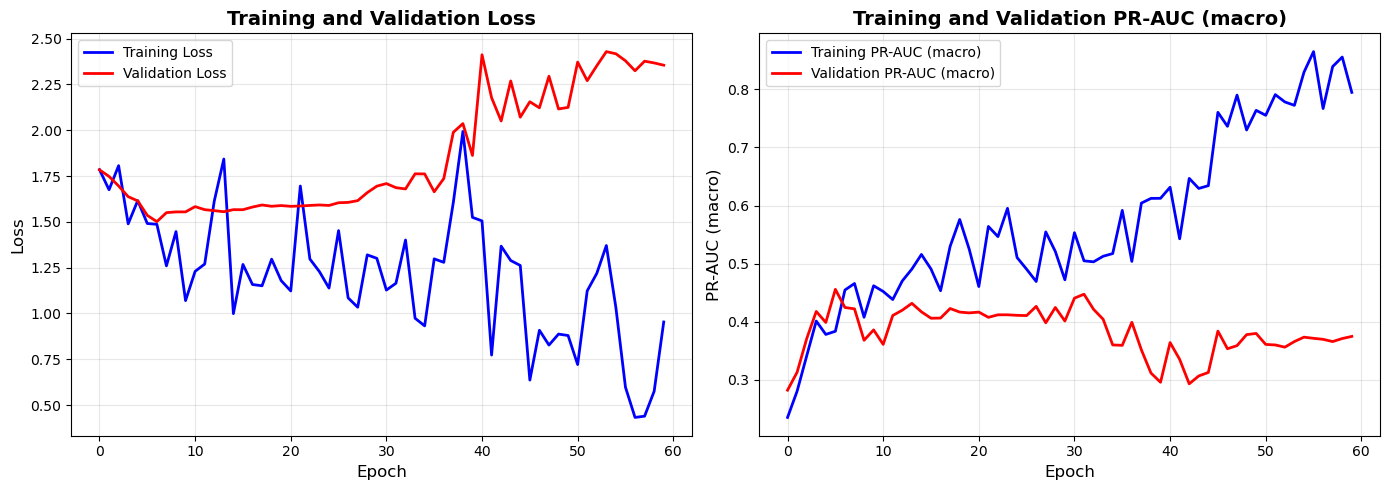

In [10]:
import matplotlib.pyplot as plt

# Plot training history from PyTorch Lightning logs
metrics_df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
train_loss = metrics_df.dropna(subset=['train_loss'])
val_loss = metrics_df.dropna(subset=['val_loss'])

ax1.plot(train_loss['epoch'], train_loss['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(val_loss['epoch'], val_loss['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot metric curves
metric_name = METRIC_CONFIG[PRIMARY_METRIC]['monitor']
train_metric_name = metric_name.replace('val_', 'train_')
train_metric = metrics_df.dropna(subset=[train_metric_name])
val_metric = metrics_df.dropna(subset=[metric_name])

ax2.plot(train_metric['epoch'], train_metric[train_metric_name], 'b-', 
         label=f'Training {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.plot(val_metric['epoch'], val_metric[metric_name], 'r-', 
         label=f'Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel(METRIC_CONFIG[PRIMARY_METRIC]['name'], fontsize=12)
ax2.set_title(f'Training and Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Load best model and evaluate
best_model = FlagPatternClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    weights_only=False  # Allow loading numpy arrays from checkpoint
)
best_model.eval()
best_model.freeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

def get_predictions(loader, model):
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_targets), np.concatenate(all_probs)

train_preds, train_targets, train_probs = get_predictions(train_loader, best_model)
val_preds, val_targets, val_probs = get_predictions(val_loader, best_model)

# Calculate metrics
train_acc = accuracy_score(train_targets, train_preds)
train_f1 = f1_score(train_targets, train_preds, average='macro')
train_auc_ovo = roc_auc_score(train_targets, train_probs, multi_class='ovo', average='macro')
train_auc_ovr = roc_auc_score(train_targets, train_probs, multi_class='ovr', average='macro')

val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')
val_auc_ovo = roc_auc_score(val_targets, val_probs, multi_class='ovo', average='macro')
val_auc_ovr = roc_auc_score(val_targets, val_probs, multi_class='ovr', average='macro')

train_targets_bin = label_binarize(train_targets, classes=range(num_classes))
val_targets_bin = label_binarize(val_targets, classes=range(num_classes))

train_pr_auc_per_class = [average_precision_score(train_targets_bin[:, i], train_probs[:, i]) for i in range(num_classes)]
val_pr_auc_per_class = [average_precision_score(val_targets_bin[:, i], val_probs[:, i]) for i in range(num_classes)]

train_pr_auc = np.mean(train_pr_auc_per_class)
val_pr_auc = np.mean(val_pr_auc_per_class)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Train F1 (macro): {train_f1:.4f}")
print(f"Train PR-AUC (macro): {train_pr_auc:.4f}")
print(f"Train AUC-ROC (OvO): {train_auc_ovo:.4f}")
print(f"Train AUC-ROC (OvR): {train_auc_ovr:.4f}")
print(f"\nVal accuracy: {val_acc:.4f}")
print(f"Val F1 (macro): {val_f1:.4f}")
print(f"Val PR-AUC (macro): {val_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
print(f"Val AUC-ROC (OvO): {val_auc_ovo:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovo' else ''}")
print(f"Val AUC-ROC (OvR): {val_auc_ovr:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovr' else ''}")

Train accuracy: 0.4522
Train F1 (macro): 0.3748
Train PR-AUC (macro): 0.5314
Train AUC-ROC (OvO): 0.8621
Train AUC-ROC (OvR): 0.8632

Val accuracy: 0.4138
Val F1 (macro): 0.3555
Val PR-AUC (macro): 0.4560 ← PRIMARY METRIC
Val AUC-ROC (OvO): 0.7784 
Val AUC-ROC (OvR): 0.7753 


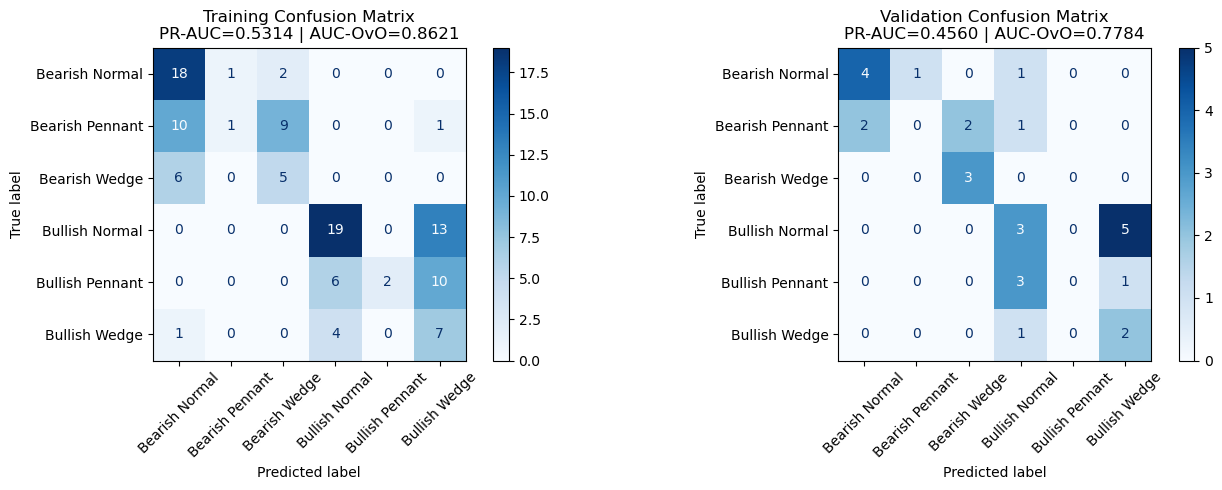


Classification report (validation):
                 precision    recall  f1-score   support

 Bearish Normal       0.67      0.67      0.67         6
Bearish Pennant       0.00      0.00      0.00         5
  Bearish Wedge       0.60      1.00      0.75         3
 Bullish Normal       0.33      0.38      0.35         8
Bullish Pennant       0.00      0.00      0.00         4
  Bullish Wedge       0.25      0.67      0.36         3

       accuracy                           0.41        29
      macro avg       0.31      0.45      0.36        29
   weighted avg       0.32      0.41      0.35        29



/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

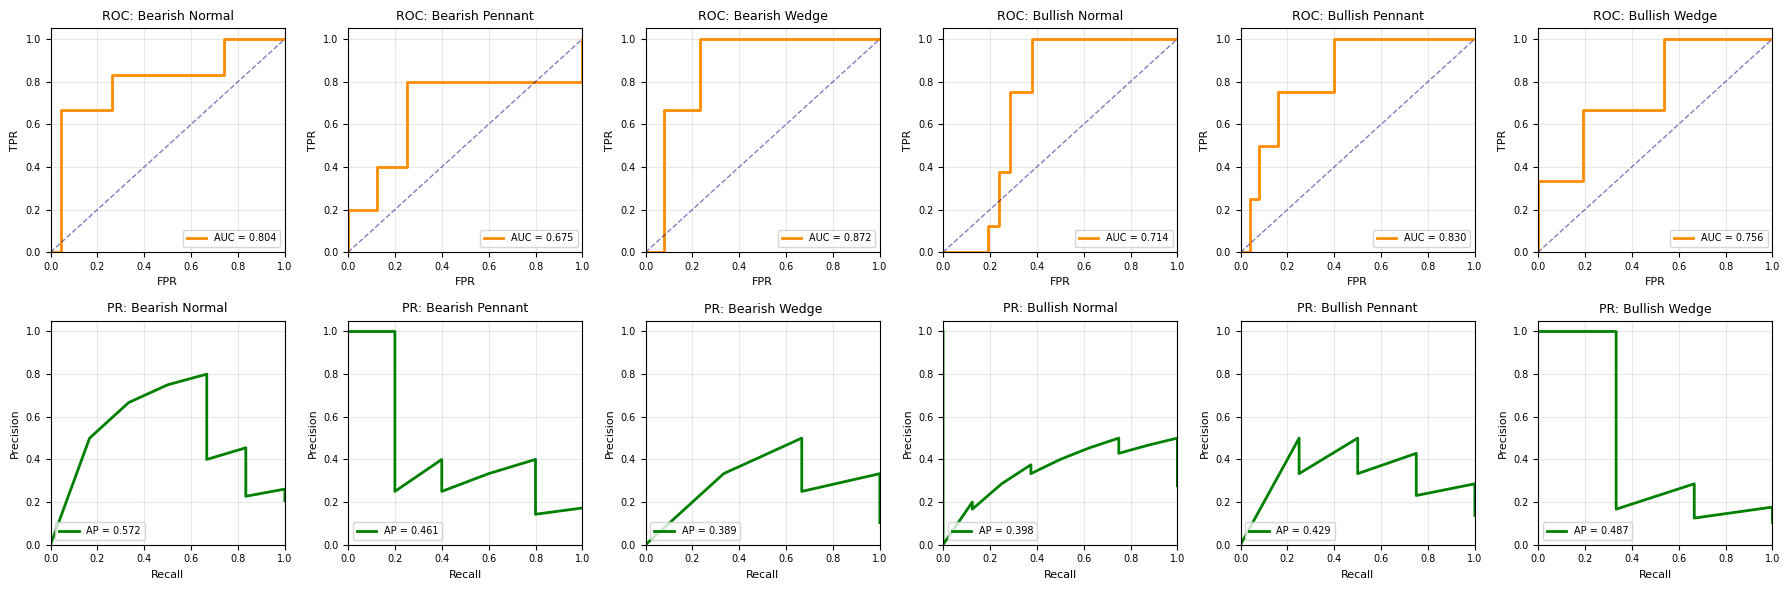

In [13]:
# Visualization - Confusion matrices and curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_train = confusion_matrix(train_targets, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_values)
disp_train.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title(f"Training Confusion Matrix\nPR-AUC={train_pr_auc:.4f} | AUC-OvO={train_auc_ovo:.4f}")

cm_val = confusion_matrix(val_targets, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_values)
disp_val.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title(f"Validation Confusion Matrix\nPR-AUC={val_pr_auc:.4f} | AUC-OvO={val_auc_ovo:.4f}")

plt.tight_layout()
plt.show()

print("\nClassification report (validation):")
print(classification_report(val_targets, val_preds, target_names=[str(lbl) for lbl in label_values]))

# Plot ROC and PR curves
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(num_classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(val_targets_bin[:, i], val_probs[:, i])
    roc_auc_class = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_class:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('FPR', fontsize=8)
    axes[0, i].set_ylabel('TPR', fontsize=8)
    axes[0, i].set_title(f'ROC: {label_values[i]}', fontsize=9)
    axes[0, i].legend(loc="lower right", fontsize=7)
    axes[0, i].grid(alpha=0.3)
    axes[0, i].tick_params(labelsize=7)
    
    # PR curve
    precision, recall, _ = precision_recall_curve(val_targets_bin[:, i], val_probs[:, i])
    pr_auc_class = val_pr_auc_per_class[i]
    
    axes[1, i].plot(recall, precision, color='green', lw=2, label=f'AP = {pr_auc_class:.3f}')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall', fontsize=8)
    axes[1, i].set_ylabel('Precision', fontsize=8)
    axes[1, i].set_title(f'PR: {label_values[i]}', fontsize=9)
    axes[1, i].legend(loc="lower left", fontsize=7)
    axes[1, i].grid(alpha=0.3)
    axes[1, i].tick_params(labelsize=7)

plt.tight_layout()
plt.show()

In [14]:
# Reload the baseline_model module to pick up any changes
import importlib
import sys

# Remove cached module if it exists
if 'baseline_model' in sys.modules:
    del sys.modules['baseline_model']

# Re-import
import baseline_model
print("Baseline model reloaded with current slope_threshold:", baseline_model.BaselineModel().slope_threshold)

Baseline model reloaded with current slope_threshold: 0.0002


Using segments CSV for baseline: /work/data/export/segments_values.csv
Baseline results shape: (144, 4)
Using slope_threshold: 0.0002
Number of evaluated segments: 144
Baseline accuracy: 0.3542
Baseline F1 score (macro): 0.3129
Baseline classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Classification report (baseline):
                 precision    recall  f1-score   support

 Bearish Normal       0.38      0.33      0.35        27
Bearish Pennant       0.29      0.15      0.20        26
  Bearish Wedge       0.24      0.50      0.33        14
 Bullish Normal       0.55      0.57      0.56        40
Bullish Pennant       0.38      0.14      0.20        22
  Bullish Wedge       0.19      0.33      0.24        15

       accuracy                           0.35       144
      macro avg       0.33      0.34      0.31       144
   weighted avg       0.37      0.35      0.35       144



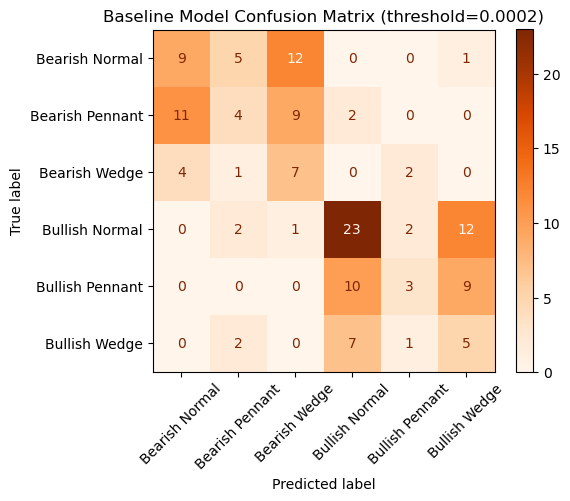

In [15]:
# Evaluate baseline model on the combined segments CSV and plot confusion matrix
import os
from baseline_model import predict_from_segments_csv, evaluate_on_segments_csv

# Path to the combined segment CSV produced by 01-data-exploration.ipynb
segments_csv_path = os.path.abspath("../data/export/segments_values.csv")
print("Using segments CSV for baseline:", segments_csv_path)

# Custom slope threshold for baseline model
BASELINE_SLOPE_THRESHOLD = 0.0002

# Run baseline model on all segments; this returns a DataFrame
baseline_results = predict_from_segments_csv(segments_csv_path, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print("Baseline results shape:", baseline_results.shape)
print(f"Using slope_threshold: {BASELINE_SLOPE_THRESHOLD}")

# Keep only rows with ground-truth labels
mask = baseline_results["gold_label"].notna()
baseline_labels = baseline_results.loc[mask, "gold_label"].values
baseline_preds = baseline_results.loc[mask, "predicted_label"].values

print("Number of evaluated segments:", baseline_labels.shape[0])

# Print accuracy, F1 score, and classification report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
baseline_acc = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 score (macro): {baseline_f1:.4f}")

# Use label set from the baseline outputs
import numpy as np
baseline_label_values = np.sort(pd.unique(baseline_labels))
print("Baseline classes:", baseline_label_values)

print("\nClassification report (baseline):")
print(classification_report(baseline_labels, baseline_preds,
                            labels=baseline_label_values,
                            target_names=[str(lbl) for lbl in baseline_label_values]))

# Plot confusion matrix for baseline model
import matplotlib.pyplot as plt
cm_baseline = confusion_matrix(baseline_labels, baseline_preds, labels=baseline_label_values)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=baseline_label_values)
fig, ax = plt.subplots(figsize=(6, 5))
disp_baseline.plot(ax=ax, cmap="Oranges", xticks_rotation=45)
ax.set_title(f"Baseline Model Confusion Matrix (threshold={BASELINE_SLOPE_THRESHOLD})")
plt.tight_layout()
plt.show()

In [ ]:
# Compare confusion matrices of CNN model vs baseline on all segments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# 1) CNN model predictions on all segments used for training
full_ds = SegmentDataset(X, y_idx)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

cnn_preds_all, cnn_targets_all, cnn_probs_all = get_predictions(full_loader, best_model)

# Map integer indices back to label strings
cnn_true_labels = np.vectorize(idx_to_label.get)(cnn_targets_all)
cnn_pred_labels = np.vectorize(idx_to_label.get)(cnn_preds_all)

# Calculate all CNN metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_pred_labels)
cnn_f1 = f1_score(cnn_true_labels, cnn_pred_labels, average='macro')
cnn_auc_ovo = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovo', average='macro')
cnn_auc_ovr = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovr', average='macro')

# Calculate PR-AUC for CNN
cnn_targets_bin = label_binarize(cnn_targets_all, classes=range(num_classes))
cnn_pr_auc_per_class = [average_precision_score(cnn_targets_bin[:, i], cnn_probs_all[:, i]) for i in range(num_classes)]
cnn_pr_auc = np.mean(cnn_pr_auc_per_class)

# 2) Baseline predictions (already computed from segments_values.csv)
#    Using baseline_labels and baseline_preds from the previous cell

# Use the global label set from the CNN pipeline for consistent ordering
all_labels = label_values
print("Confusion matrix classes (ordered):", all_labels)

cm_cnn_all = confusion_matrix(cnn_true_labels, cnn_pred_labels, labels=all_labels)
cm_baseline_all = confusion_matrix(baseline_labels, baseline_preds, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN confusion matrix
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_all, display_labels=all_labels)
cnn_disp.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model Confusion Matrix (All Segments)\n"
                  f"Primary: {METRIC_CONFIG[PRIMARY_METRIC]['name']} | "
                  f"PR-AUC: {cnn_pr_auc:.4f} | AUC-OvO: {cnn_auc_ovo:.4f}")

# Baseline confusion matrix
base_disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_all, display_labels=all_labels)
base_disp.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model Confusion Matrix (All Segments)\nAccuracy: {baseline_acc:.4f}")

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"CNN Model (selected by {METRIC_CONFIG[PRIMARY_METRIC]['name']}):")
print(f"  Accuracy:         {cnn_acc:.4f}")
print(f"  F1 Score (macro): {cnn_f1:.4f}")
print(f"  PR-AUC (macro):   {cnn_pr_auc:.4f}  ← precision-recall curve")
print(f"  AUC-ROC (OvO):    {cnn_auc_ovo:.4f}  ← pairwise discrimination (15 comparisons)")
print(f"  AUC-ROC (OvR):    {cnn_auc_ovr:.4f}  ← each-vs-rest (6 comparisons)")
print(f"\nBaseline Model (heuristic):")
print(f"  Accuracy:         {baseline_acc:.4f}")
print(f"  F1 Score (macro): {baseline_f1:.4f}")
print("="*70)
print(f"\nPR-AUC is particularly useful for imbalanced datasets")
print(f"It focuses on positive class performance and precision-recall trade-offs")

TypeError: get_predictions() missing 1 required positional argument: 'model'